In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Dataset

In [3]:
file_path = 'no2.txt'
df = pd.read_csv(file_path, delimiter=' ')
df.head()

,no2,cars,temp,windspeed,tempdiff,winddir,hour,day
0,22.199949,2206.008383,6.4,3.5,-0.3,56,14,196
1,80.500227,1044.997738,-7.2,1.7,1.2,74,23,143
2,77.200042,1840.992302,-1.3,2.6,-0.1,65,11,115
3,46.200009,333.999668,-3.1,1.8,0.3,78,2,55
4,88.399826,3323.986186,1.0,1.2,1.5,215,18,47


First we analyze the distributions and pairplots of features present in the dataset. For example we can notice that the `NO2` distribution has heavy tail. Pairplots for features (excluding target variable) do not show any particular strong correlation. Another note is that treating day as numerical predictor might not be that sensible, however any one hot encoding for this variable makes even less sense.

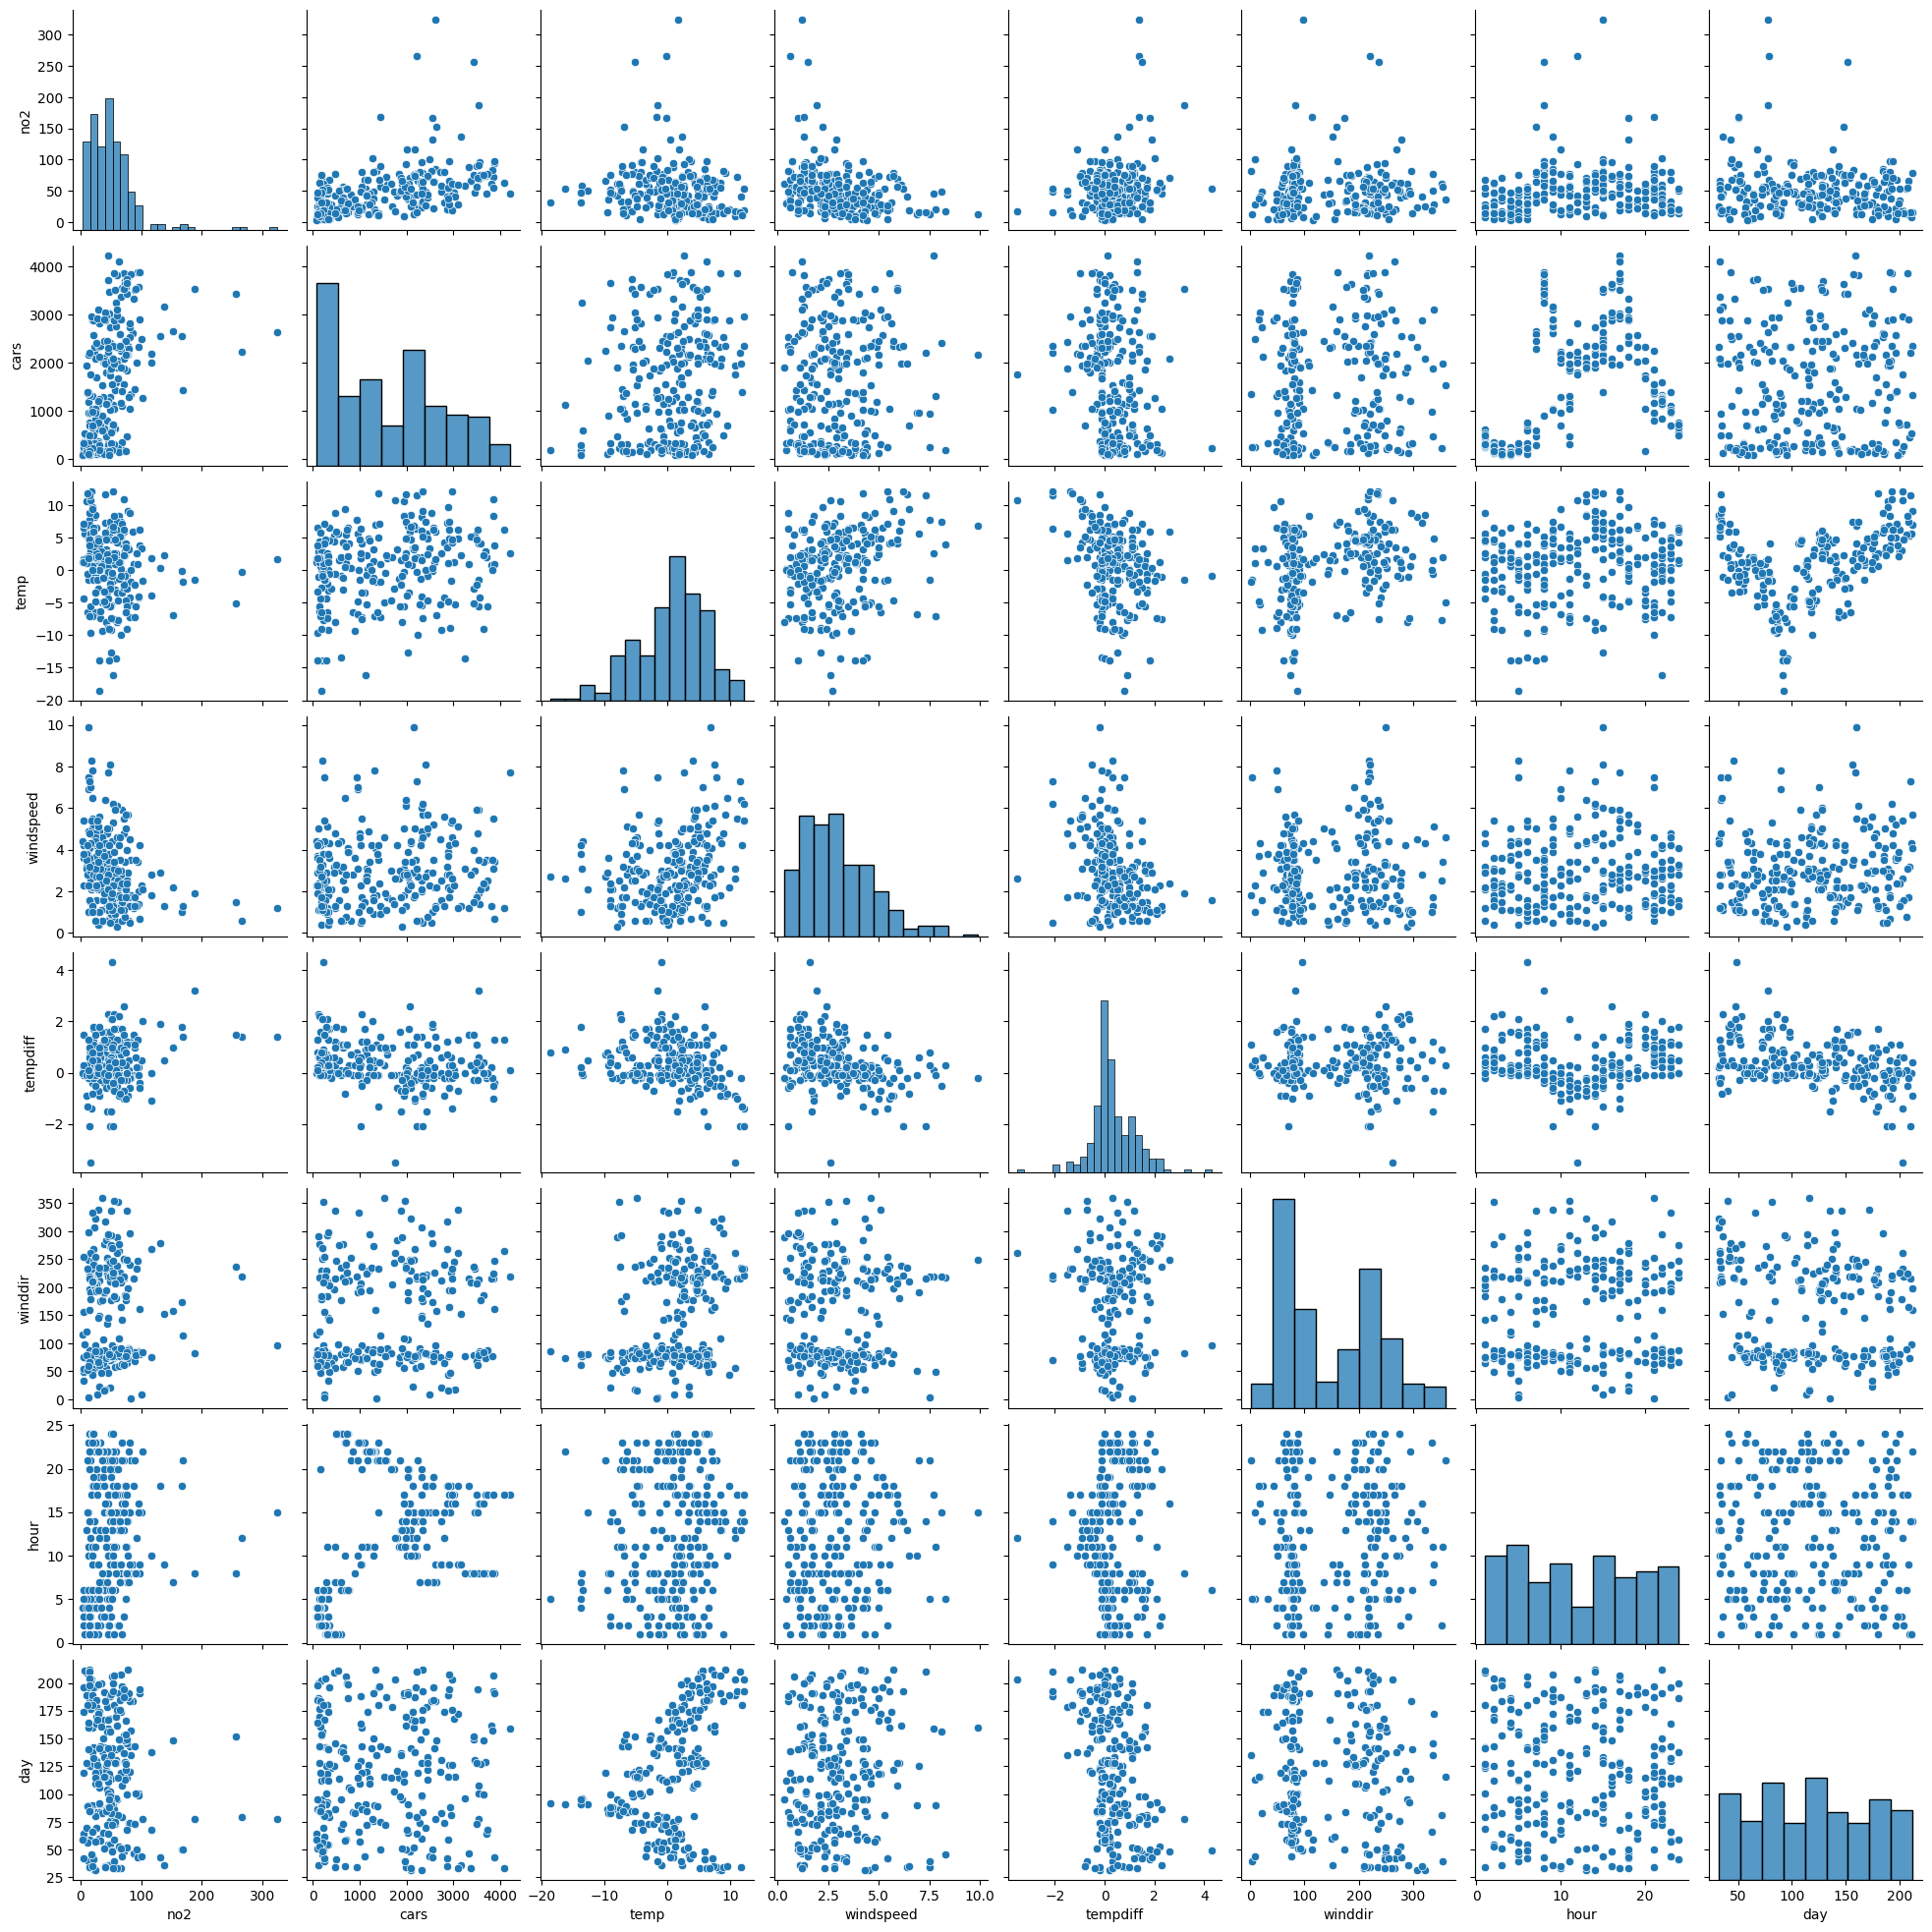

In [5]:
sns.pairplot(df)
plt.show()

In [48]:
df.describe()

,no2,cars,temp,windspeed,tempdiff,winddir,hour,day
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,50.510360,1598.581544,0.707171,3.008765,0.333068,151.633466,12.139442,119.358566
std,39.490877,1158.345338,5.626803,1.733783,0.877805,87.117949,6.965664,52.133664
min,3.900013,75.000141,-18.600000,0.300000,-3.500000,2.000000,1.000000,32.000000
25%,24.799909,456.498585,-2.800000,1.700000,-0.100000,77.000000,6.000000,78.000000
50%,45.399904,1444.993352,1.500000,2.800000,0.200000,135.000000,12.000000,119.000000
75%,64.950166,2442.996788,4.800000,4.150000,0.800000,224.000000,18.000000,165.000000
max,324.099316,4224.009186,12.200000,9.900000,4.300000,359.000000,24.000000,212.000000


# Feature collinearity

We verify if there are any collinearities between predictors and thus if any of the predictors should be removed from our training set. We use Variance Inflation Factor (VIF) and correlation matrix for validation of our findings.

In [4]:
X = sm.add_constant(df)

## VIF

In [50]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

selected_features = X.drop(columns=['no2'])
calculate_vif(selected_features)

,Feature,VIF
0,const,24.241779
1,cars,1.243074
2,temp,1.512238
3,windspeed,1.192568
4,tempdiff,1.418973
5,winddir,1.229814
6,hour,1.167743
7,day,1.351740


All of the features have VIF $\sim$ 1, suggesting no major collinearities. The variance of the regression coefficients is not inflated. We validate that observation by looking at the correlation matrix. As we can see, the predictors are not highly correlated, which is a good sign. The biggest observable correlation is between `no2` and `cars` ($\sim$ 0.45), which might be a suggestion that the number of cars is a valuable predictor. 

## Correlation matrix

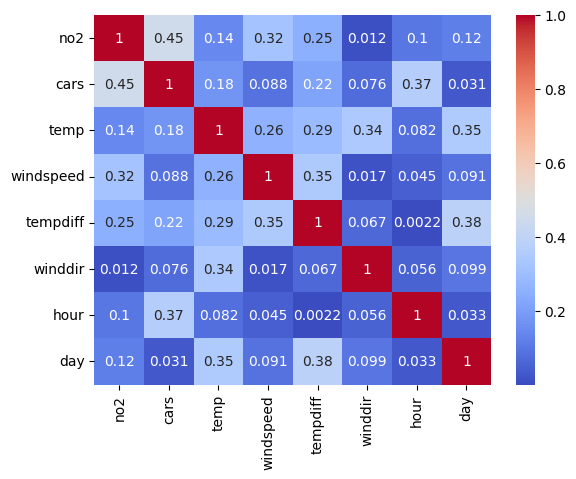

In [54]:
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Linear regression on full data

## Summary

In [5]:
formula = 'no2 ~ ' + '+'.join(X.columns.difference(['no2']))  
model = smf.ols(formula, data=X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     24.21
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           6.77e-25
Time:                        18:00:57   Log-Likelihood:                -1211.9
No. Observations:                 251   AIC:                             2440.
Df Residuals:                     243   BIC:                             2468.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6681      4.777      3.908      0.000       9.258      28.078
cars           0.0198      0.002     10.603      0.000       0.016       0.024
const         18.6681      4.777      3.908      0.000       9.258      28.078
day            0.0131      0.043      0.303      0.762      -0.072       0.099
hour          -0.5144      0.302     -1.705      0.089      -1.109       0.080
temp          -0.6995      0.425     -1.646      0.101      -1.537       0.138
tempdiff      12.0540      2.639      4.568      0.000       6.857      17.252
winddir       -0.0025      0.025     -0.100      0.920      -0.051       0.046
windspeed     -5.6553      1.225     -4.618      0.000      -8.068      -3.243
==============================================================================
Omnibus:                      210.841   Durbin-Watson:                   2.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4141.571
Skew:                           3.223   Prob(JB):                         0.00
Kurtosis:                      21.827   Cond. No.                     1.11e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.93e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The $R^2$ and adjusted $R^2$ indexes are relatively small and might signal not great fit of linear regression model.
P-value for F-statistic is small and we can assume that not all of the predictors are insignificant. However, looking at the t-tests for predictor significance, we can observe high p-value for `winddir` and `day` columns, suggesting the removal of these predictors from model. Of course, removing variables can only lead to increase of SSE on the training data, but can improve generalisation on test data and overall interpretability of model.

Also p-values for `hour` and `temp` are higher than 0.05 which could indicate that these variables are also insignificant and removing these variables should at least be considered.  

## MSE for full model

In [6]:
MSE = mean_squared_error(X['no2'], model.predict(X))
print(f'MSE: {MSE}')

MSE: 915.0655311951564


# Model after excluding `winddir` and `day` predictors

## Summary

In [28]:
formula = 'no2 ~ ' + '+'.join(X.columns.difference(['no2', 'winddir', 'day']))  
model = smf.ols(formula, data=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     34.14
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           2.08e-26
Time:                        04:22:17   Log-Likelihood:                -1212.0
No. Observations:                 251   AIC:                             2436.
Df Residuals:                     245   BIC:                             2457.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.4244      2.872      6.763      0.000      13.768      25.081
cars           0.0198      0.002     10.654      0.000       0.016       0.023
const         19.4244      2.872      6.763      0.000      13.768      25.081
hour          -0.5170      0.300     -1.721      0.086      -1.109       0.075
temp          -0.6792      0.368     -1.844      0.066      -1.405       0.046
tempdiff      11.7343      2.461      4.768      0.000       6.887      16.582
windspeed     -5.6911      1.212     -4.696      0.000      -8.078      -3.304
==============================================================================
Omnibus:                      210.498   Durbin-Watson:                   2.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4120.157
Skew:                           3.217   Prob(JB):                         0.00
Kurtosis:                      21.777   Cond. No.                     9.70e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## MSE

In [30]:
MSE = mean_squared_error(X['no2'], model.predict(X))
MSE

915.5139090872674

After excluding 2 `day` and `winddir` variables from the set of predictors we barely increase MSE on training, while reduce complexity of model and potentially improve generalization.

# Diagnostics

## Distribution of residuals

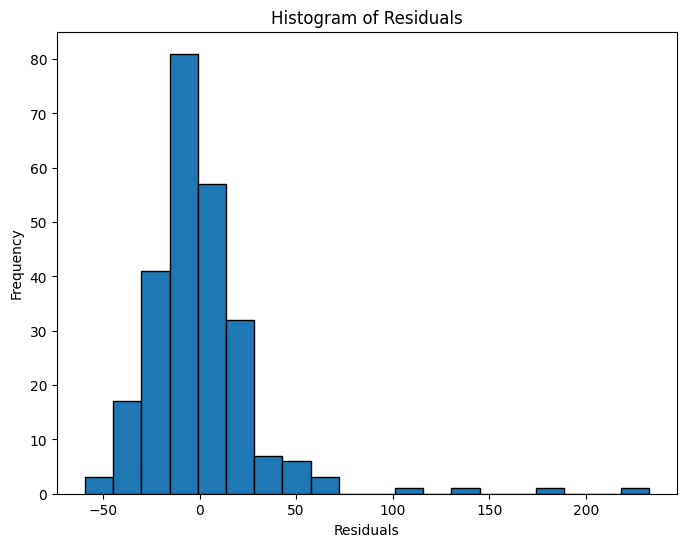

Shapiro-Wilk Test Statistic: 0.7688661343173065
Shapiro-Wilk p-value: 1.6377012765726963e-18


In [64]:
from scipy.stats import shapiro

residuals = model.resid

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_statistic}")
print(f"Shapiro-Wilk p-value: {shapiro_p_value}")

The residuals of the linear regression model should optimally have normal distribution. The histogram shows some concern and Shapiro-Wilk test was conducted to statistically verify the hypothesis of normality of residuals. The p-value is very low, suggesting to discard the null hypothesis about the normality of the residuals.

## QQ-plot

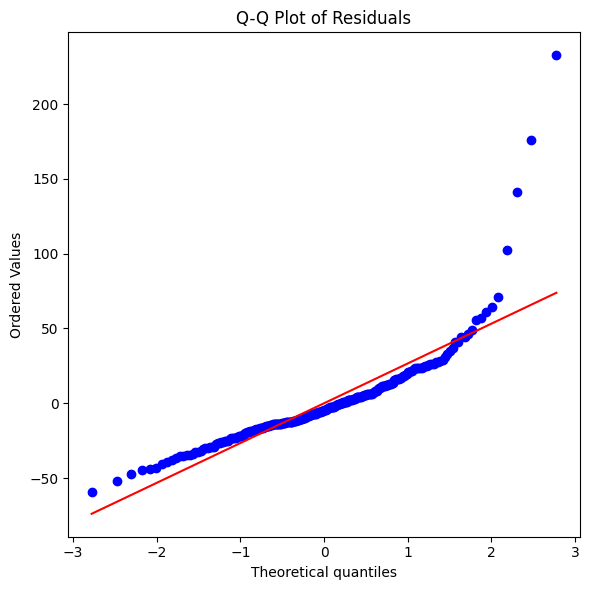

In [31]:
residuals = model.resid

fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

The QQ-plot reinforces the hypotheses that the residuals do not fulfill normality assumption.

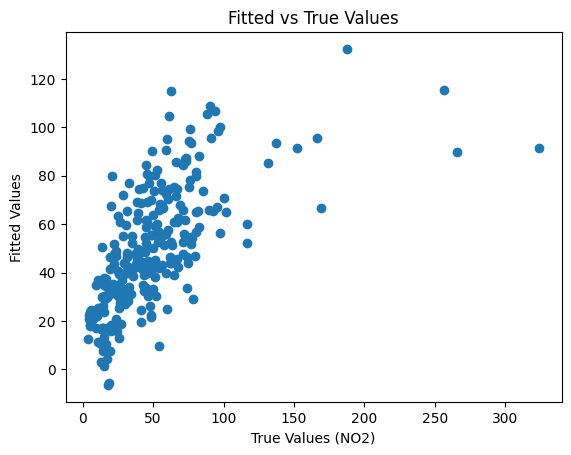

In [33]:
plt.scatter(df['no2'], model.fittedvalues)
plt.xlabel('True Values (NO2)')
plt.ylabel('Fitted Values')
plt.title('Fitted vs True Values')
plt.show()

The desirable shape for the points from this plot would be a straight line. Unfortunately we can see some anomalies for larger values of the NO2.

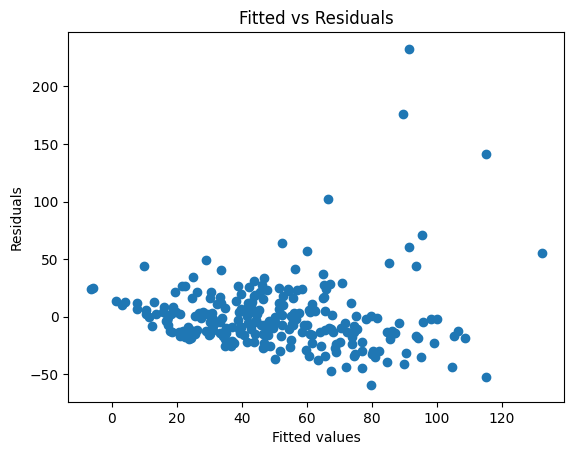

In [58]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted vs Residuals')
plt.show()

## Partial residual plots

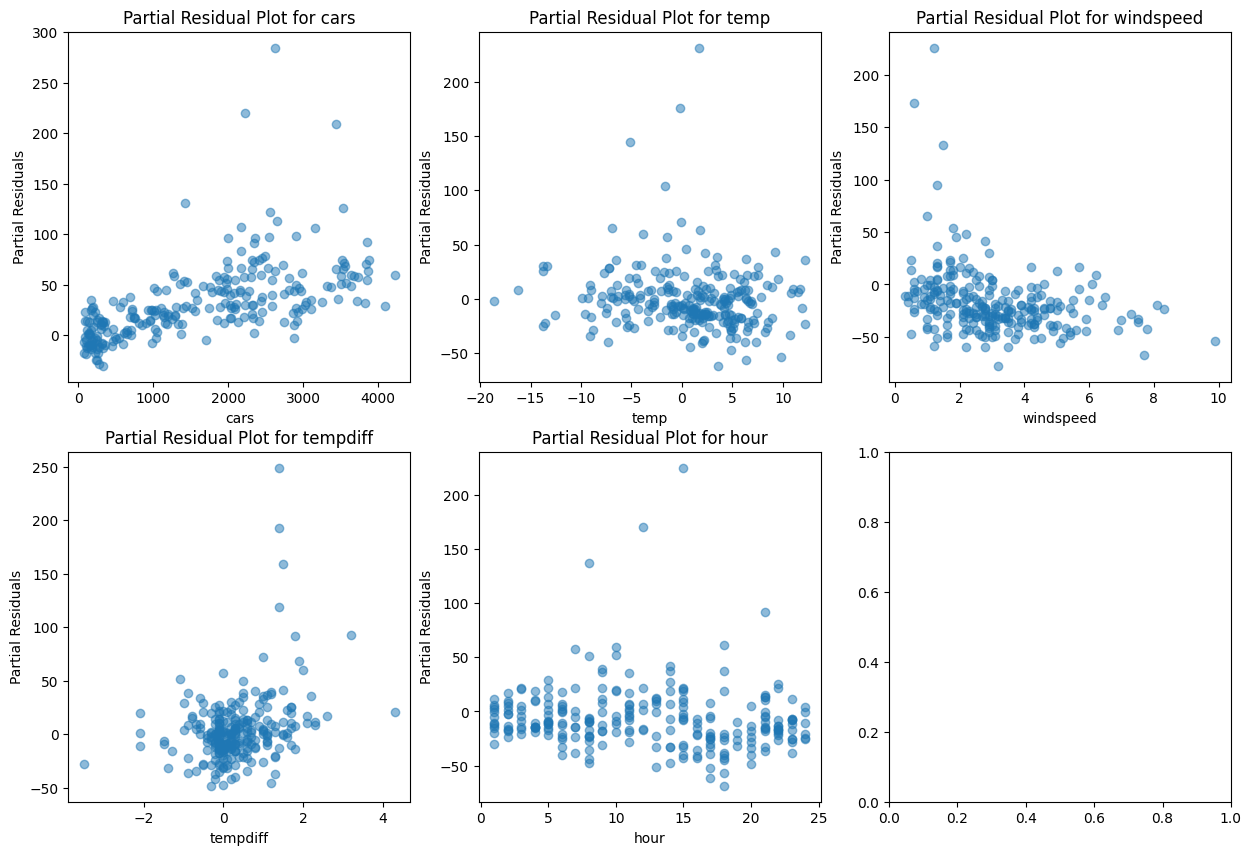

In [62]:
independent_variables = X.drop(columns=['no2', 'winddir', 'day']).columns[1:]

num_plots = len(independent_variables)
num_cols = 3  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_plots / num_cols))  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

axes = axes.flatten()

for i, var in enumerate(independent_variables):
    partial_resid = model.resid + X[var] * model.params[var]
    axes[i].scatter(X[var], partial_resid, alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Partial Residuals')
    axes[i].set_title(f'Partial Residual Plot for {var}')

## Box-cox transformation

One possibility to stabilize variance and normalize distributions of `NO2` and `cars` variables is to apply Box-Cox transformation. After the transformation, I verify if it gives some improvement for the model.

Lambda value used for transformation: 0.1939379324703674


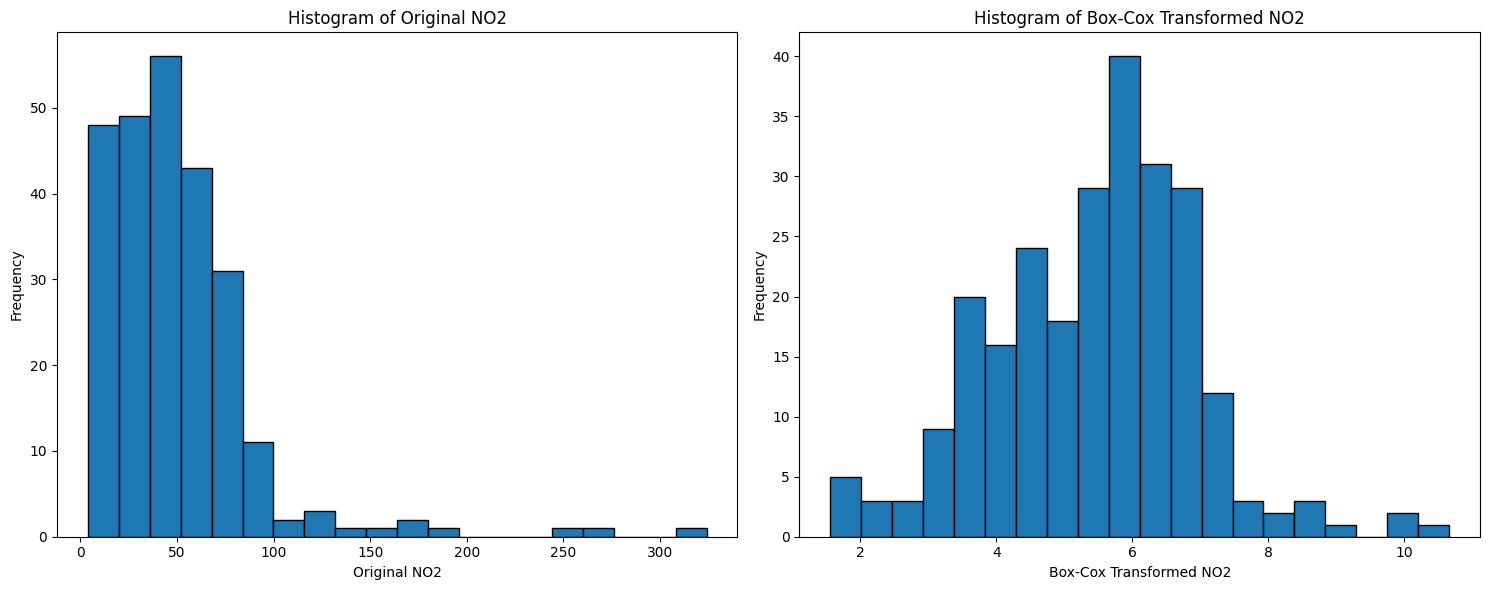

In [8]:
boxcox_no2, lmbda = stats.boxcox(df['no2'])
print(f"Lambda value used for transformation: {lmbda}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df['no2'], bins=20, edgecolor='black')
plt.title('Histogram of Original NO2')
plt.xlabel('Original NO2')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(boxcox_no2, bins=20, edgecolor='black')
plt.title('Histogram of Box-Cox Transformed NO2')
plt.xlabel('Box-Cox Transformed NO2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


As we can see, box-cox transformation normalized values of NO2 variable. We do the same for `cars` variable and fit a model with transformed ones.

# Model after transformation

## Summary

In [9]:
boxcox_cars, lmbda = stats.boxcox(df['cars'])
X['no2_boxcox'] = boxcox_no2
X['cars_boxcox'] = boxcox_cars
formula = 'no2_boxcox ~ cars_boxcox+const+hour+temp+tempdiff+windspeed'
model = smf.ols(formula, data=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             no2_boxcox   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     60.52
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           6.96e-41
Time:                        18:07:30   Log-Likelihood:                -355.77
No. Observations:                 251   AIC:                             723.5
Df Residuals:                     245   BIC:                             744.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9732      0.110     17.930      0.000       1.756       2.190
cars_boxcox     0.0467      0.003     14.171      0.000       0.040       0.053
const           1.9732      0.110     17.930      0.000       1.756       2.190
hour           -0.0308      0.011     -2.922      0.004      -0.052      -0.010
temp           -0.0457      0.012     -3.756      0.000      -0.070      -0.022
tempdiff        0.4094      0.082      4.991      0.000       0.248       0.571
windspeed      -0.2521      0.040     -6.299      0.000      -0.331      -0.173
==============================================================================
Omnibus:                        1.314   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.010
Skew:                           0.119   Prob(JB):                        0.604
Kurtosis:                       3.200   Cond. No.                     3.03e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In order to calculate MSE, we need to find the inverse function of our Box-Cox transformation.

## MSE

In [10]:
lmbda = 0.1939379324703674
y_true = X['no2']
y_pred = (lmbda * (model.predict(X)) + 1) ** (1 / lmbda)
MSE = mean_squared_error(y_true, y_pred)
print(f'MSE: {MSE}')

MSE: 862.3729217742655


The MSE is significantly reduced and $R^2$ index increased by over 0.1, which is a solid improvement.

## Residuals 

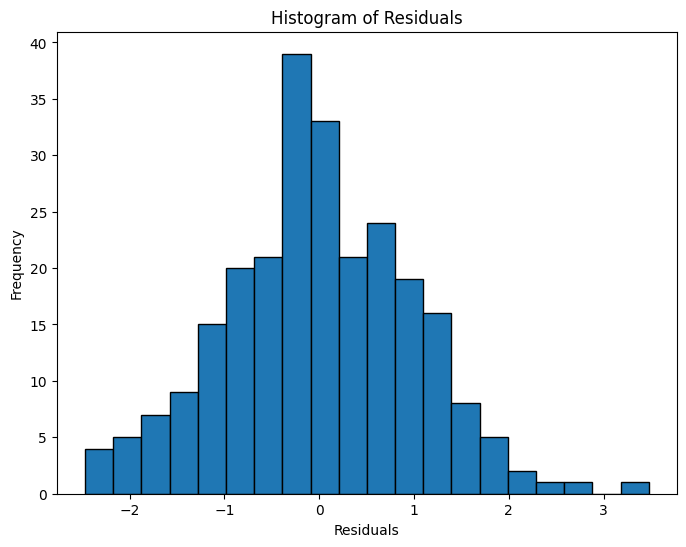

Shapiro-Wilk Test Statistic: 0.9948681045940815
Shapiro-Wilk p-value: 0.5631110423306341


In [51]:
from scipy.stats import shapiro

residuals = model.resid

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_statistic}")
print(f"Shapiro-Wilk p-value: {shapiro_p_value}")

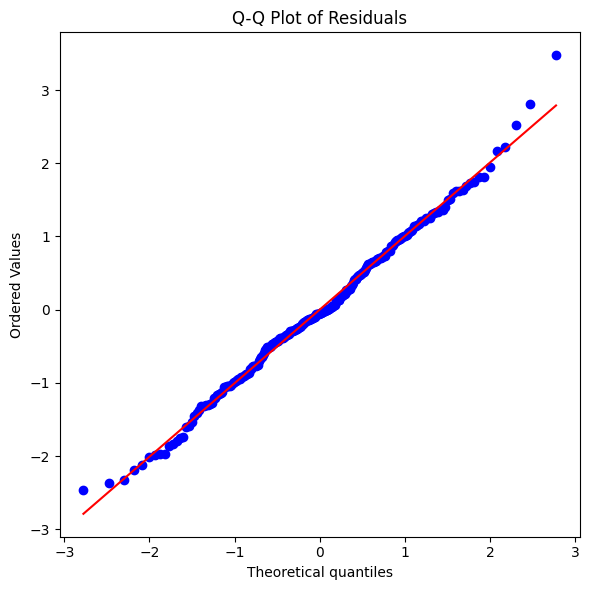

In [52]:
residuals = model.resid

fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

Also the residuals improved and they pass Shapiro-Wilk test for normality of distribution. Quantiles on QQ-plot almost perfectly resemble the normal distribution.

# Outlier detection

At last we analyse the influence of outlier removal on the results. We use Cook's distance for outlier detection and set threshold based on sample size (typically $\frac{4}{N}$ is considered a reasonable threshold) 

In [14]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
cooks_distance = influence.cooks_distance[0]
cooks_threshold = 4 / len(df)

X_without_outliers = X[cooks_distance <= cooks_threshold]
formula = 'no2_boxcox ~ cars_boxcox+const+hour+temp+tempdiff+windspeed'
model = smf.ols(formula, data=X_without_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             no2_boxcox   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     61.32
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           9.12e-41
Time:                        18:10:10   Log-Likelihood:                -320.16
No. Observations:                 242   AIC:                             652.3
Df Residuals:                     236   BIC:                             673.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9831      0.101     19.704      0.000       1.785       2.181
cars_boxcox     0.0445      0.003     14.496      0.000       0.038       0.051
const           1.9831      0.101     19.704      0.000       1.785       2.181
hour           -0.0280      0.010     -2.876      0.004      -0.047      -0.009
temp           -0.0478      0.011     -4.175      0.000      -0.070      -0.025
tempdiff        0.3677      0.077      4.757      0.000       0.215       0.520
windspeed      -0.2364      0.037     -6.364      0.000      -0.310      -0.163
==============================================================================
Omnibus:                        1.507   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.578
Skew:                          -0.150   Prob(JB):                        0.454
Kurtosis:                       2.742   Cond. No.                     4.70e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
lmbda = 0.1939379324703674
y_true = X['no2']
y_pred = (lmbda * (model.predict(X)) + 1) ** (1 / lmbda)
MSE = mean_squared_error(y_true, y_pred)
print(f'MSE: {MSE}')

MSE: 890.2473820578655


We can notice that the fit of the model is better, but it should be intuitive as we removed the annoying observations. But the MSE calculated on the whole data grows. 